# Prédictions du cancer

## Librairies et fonctions utiles 

In [1]:
# Directive pour afficher les graphiques dans Jupyter
%matplotlib inline

In [2]:
# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from IPython.core.display import HTML # permet d'afficher du code html dans jupyter

 Fonction pour standardiser les données quantitatives (cont_feat est une liste des colonnes correspondant à des caractéristiques quantitatives) :

In [3]:
def scale_feat(df,cont_feat) :
    df1=df
    scaler = preprocessing.RobustScaler()
    df1[cont_feat] = scaler.fit_transform(df1[cont_feat])
    scaler = preprocessing.StandardScaler()
    df1[cont_feat] = scaler.fit_transform(df1[cont_feat]) 
    return df1

In [4]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=est, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(b='on')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.show()

In [5]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
    plt.plot([0,0,1],[0,1,1],'g:')     # meilleure courbe
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

In [6]:
def undersample(df, target_col, minority_class) :
    df_minority = df[df[target_col] == minority_class]
    df_majority = df.drop(df_minority.index)
    ratio=len(df_minority)/len(df_majority)
    df_majority = df_majority.sample(frac=ratio)
    df1 = pd.concat((df_majority,df_minority), axis=0)
    return df1.sample(frac=1)

# Traitement du dataset: Cancer

In [49]:
# Lecture des données d'apprentissage et de test
cancer = pd.read_csv("cancer.csv")
cancer.head(10)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   
5    843786         M        12.45         15.70           82.57      477.1   
6    844359         M        18.25         19.98          119.60     1040.0   
7  84458202         M        13.71         20.83           90.20      577.9   
8    844981         M        13.00         21.82           87.50      519.8   
9  84501001         M        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010              0.14710   
1          0.08474           0.07864         0.08690              0.07017   
2          0.10960           0.15990         0.19740              0.12790   
3          0.14250           0.28390         0.24140              0.10520   
4          0.10030           0.13280         0.19800              0.10430   
5          0.12780           0.17000         0.15780              0.08089   
6          0.09463           0.10900         0.11270              0.07400   
7          0.11890           0.16450         0.09366              0.05985   
8          0.12730           0.19320         0.18590              0.09353   
9          0.11860           0.23960         0.22730              0.08543   

            ...             radius_worst  texture_worst  perimeter_worst  \
0           ...                    25.38          17.33           184.60   
1           ...                    24.99          23.41           158.80   
2           ...                    23.57          25.53           152.50   
3           ...                    14.91          26.50            98.87   
4           ...                    22.54          16.67           152.20   
5           ...                    15.47          23.75           103.40   
6           ...                    22.88          27.66           153.20   
7           ...                    17.06          28.14           110.60   
8           ...                    15.49          30.73           106.20   
9           ...                    15.09          40.68            97.65   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   
5       741.6            0.1791             0.5249           0.5355   
6      1606.0            0.1442             0.2576           0.3784   
7       897.0            0.1654             0.3682           0.2678   
8       739.3            0.1703             0.5401           0.5390   
9       711.4            0.1853             1.0580           1.1050   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  
5                0.1741          0.3985                  0.12440  
6                0.1932          0.3063                  0.08368  
7                0.1556          0.3196                  0.11510  
8                0.2060          0.4378                  0.10720  
9 

In [50]:
cancer.diagnosis
cancer['diagnosis']

0      M
1      M
2      M
3      M
4      M
5      M
6      M
7      M
8      M
9      M
10     M
11     M
12     M
13     M
14     M
15     M
16     M
17     M
18     M
19     B
20     B
21     B
22     M
23     M
24     M
25     M
26     M
27     M
28     M
29     M
      ..
539    B
540    B
541    B
542    B
543    B
544    B
545    B
546    B
547    B
548    B
549    B
550    B
551    B
552    B
553    B
554    B
555    B
556    B
557    B
558    B
559    B
560    B
561    B
562    M
563    M
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [51]:
cancer.shape #forme des données que l'on traite

(569, 32)

In [52]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

# Différentes visualisations sur le dataset

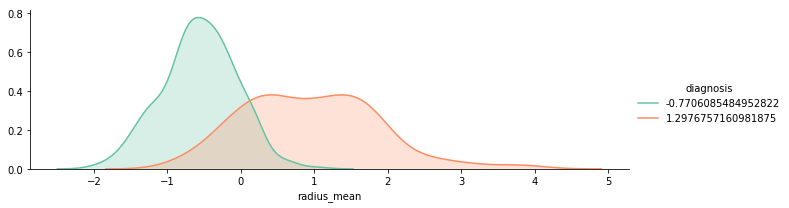

In [42]:
fig = sns.FacetGrid(cancer, hue="diagnosis", aspect=3, palette="Set2") # aspect=3 permet d'allonger le graphique
fig.map(sns.kdeplot, "radius_mean", shade=True)
fig.add_legend()

(array([357.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 212.]),
 array([-0.77060855, -0.744755  , -0.71890144, -0.69304789, -0.66719434,
        -0.64134078, -0.61548723, -0.58963368, -0.56378012, -0.53792657,
        -0.51207302, -0.48621946, -0.46036591, -0.43451236, -0.4086588 ,
        -0.38280525, -0.3569517 , -0.33109814, -0.30524459, -0.27939104,
        -0.25353748, -0.22768393, -0.20183038, -0.17597682, -0.15012327,
        -0.12426972, -0.09841616, -0.07256261, -0.04670906, -0.0208555 ,
         0.00499

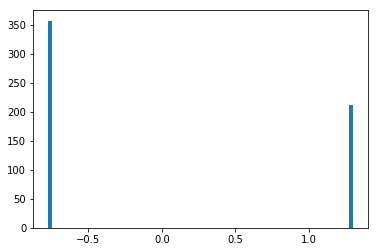

In [43]:
plt.hist(cancer.diagnosis, bins=80)  

In [45]:
cancer.age = cancer.diagnosis.astype(str)
cancer.radius_mean = cancer.radius_mean.astype(float)

(array([357.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 212.]),
 array([-0.77060855, -0.72924286, -0.68787718, -0.64651149, -0.60514581,
        -0.56378012, -0.52241444, -0.48104875, -0.43968307, -0.39831738,
        -0.3569517 , -0.31558601, -0.27422032, -0.23285464, -0.19148895,
        -0.15012327, -0.10875758, -0.0673919 , -0.02602621,  0.01533947,
         0.05670516,  0.09807084,  0.13943653,  0.18080221,  0.2221679 ,
         0.26353358,  0.30489927,  0.34626495,  0.38763064,  0.42899632,
         0.47036201,  0.5117277 ,  0.55309338,  0.59445907,  0.63582475,
         0.67719044,  0.71855612,  0.75992181,  0.80128749,  0.84265318,
         0.88401886,  0.92538455,  0.96675023,  1.00811592,  1.0494816 ,
 

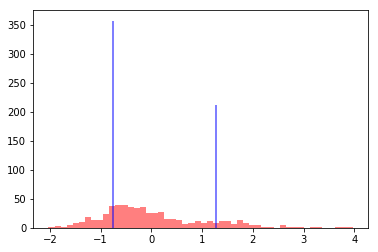

In [46]:
plt.hist(cancer.radius_mean, bins=50, color='red', alpha=0.5)
plt.hist(cancer.diagnosis, bins=50, color='blue', alpha=0.5)

In [35]:
cancer.count()#compte le nombre d'occurrence de chaque colonne

id                         569
diagnosis                  569
radius_mean                569
texture_mean               569
perimeter_mean             569
area_mean                  569
smoothness_mean            569
compactness_mean           569
concavity_mean             569
concave points_mean        569
symmetry_mean              569
fractal_dimension_mean     569
radius_se                  569
texture_se                 569
perimeter_se               569
area_se                    569
smoothness_se              569
compactness_se             569
concavity_se               569
concave points_se          569
symmetry_se                569
fractal_dimension_se       569
radius_worst               569
texture_worst              569
perimeter_worst            569
area_worst                 569
smoothness_worst           569
compactness_worst          569
concavity_worst            569
concave points_worst       569
symmetry_worst             569
fractal_dimension_worst    569
dtype: i

In [36]:
cancer["diagnosis"] = cancer["diagnosis"].map({ "B": 0, "M": 1 })#un transforme les valeurs 'B' et 'M' 
                                                                 #de la colonne en 0 et en 1 dans la datasette

In [37]:
cancer.head(10)

id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   
5    843786          1        12.45         15.70           82.57      477.1   
6    844359          1        18.25         19.98          119.60     1040.0   
7  84458202          1        13.71         20.83           90.20      577.9   
8    844981          1        13.00         21.82           87.50      519.8   
9  84501001          1        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010              0.14710   
1          0.08474           0.07864         0.08690              0.07017   
2          0.10960           0.15990         0.19740              0.12790   
3          0.14250           0.28390         0.24140              0.10520   
4          0.10030           0.13280         0.19800              0.10430   
5          0.12780           0.17000         0.15780              0.08089   
6          0.09463           0.10900         0.11270              0.07400   
7          0.11890           0.16450         0.09366              0.05985   
8          0.12730           0.19320         0.18590              0.09353   
9          0.11860           0.23960         0.22730              0.08543   

            ...             radius_worst  texture_worst  perimeter_worst  \
0           ...                    25.38          17.33           184.60   
1           ...                    24.99          23.41           158.80   
2           ...                    23.57          25.53           152.50   
3           ...                    14.91          26.50            98.87   
4           ...                    22.54          16.67           152.20   
5           ...                    15.47          23.75           103.40   
6           ...                    22.88          27.66           153.20   
7           ...                    17.06          28.14           110.60   
8           ...                    15.49          30.73           106.20   
9           ...                    15.09          40.68            97.65   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   
5       741.6            0.1791             0.5249           0.5355   
6      1606.0            0.1442             0.2576           0.3784   
7       897.0            0.1654             0.3682           0.2678   
8       739.3            0.1703             0.5401           0.5390   
9       711.4            0.1853             1.0580           1.1050   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  
5                0.1741          0.3985                  0.12440  
6                0.1932          0.3063                  0.08368  
7                0.1556          0.3196                  0.11510  
8                0.2060          0.4378                  0

In [38]:
cancer.isnull().values.sum() #revoie 0: donc pas de cases vident

0

# On retient les données importantes

In [39]:
import_data = ["diagnosis", "radius_mean", "texture_mean", "perimeter_mean","area_mean",
            "radius_worst", "texture_worst", "perimeter_worst", "area_worst","fractal_dimension_worst"]

In [40]:
cancer[import_data].describe() #on fait un peu de statistique

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       radius_worst  texture_worst  perimeter_worst   area_worst  \
count    569.000000     569.000000       569.000000   569.000000   
mean      16.269190      25.677223       107.261213   880.583128   
std        4.833242       6.146258        33.602542   569.356993   
min        7.930000      12.020000        50.410000   185.200000   
25%       13.010000      21.080000        84.110000   515.300000   
50%       14.970000      25.410000        97.660000   686.500000   
75%       18.790000      29.720000       125.400000  1084.000000   
max       36.040000      49.540000       251.200000  4254.000000   

       fractal_dimension_worst  
count               569.000000  
mean                  0.083946  
std                   0.018061  
min                   0.055040  
25%                   0.071460  
50%                   0.080040  
75%                   0.092080  
max                   0.207500

In [41]:
cancer=scale_feat(cancer,import_data)

In [15]:
cancer[import_data].describe()

diagnosis   radius_mean  texture_mean  perimeter_mean     area_mean  \
count  5.690000e+02  5.690000e+02  5.690000e+02    5.690000e+02  5.690000e+02   
mean   4.995028e-17 -3.121893e-17  2.497514e-17   -2.497514e-17  3.746271e-17   
std    1.000880e+00  1.000880e+00  1.000880e+00    1.000880e+00  1.000880e+00   
min   -7.706085e-01 -2.029648e+00 -2.229249e+00   -1.984504e+00 -1.454443e+00   
25%   -7.706085e-01 -6.893853e-01 -7.259631e-01   -6.919555e-01 -6.671955e-01   
50%   -7.706085e-01 -2.150816e-01 -1.046362e-01   -2.359800e-01 -2.951869e-01   
75%    1.297676e+00  4.693926e-01  5.841756e-01    4.996769e-01  3.635073e-01   
max    1.297676e+00  3.971288e+00  4.651889e+00    3.976130e+00  5.250529e+00   

       radius_worst  texture_worst  perimeter_worst    area_worst  \
count  5.690000e+02   5.690000e+02       569.000000  5.690000e+02   
mean  -2.497514e-17   1.873136e-17         0.000000  1.248757e-17   
std    1.000880e+00   1.000880e+00         1.000880  1.000880e+00   
min   -1.726901e+00  -2.223994e+00        -1.693361 -1.222423e+00   
25%   -6.749213e-01  -7.486293e-01        -0.689578 -6.421359e-01   
50%   -2.690395e-01  -4.351564e-02        -0.285980 -3.411812e-01   
75%    5.220158e-01   6.583411e-01         0.540279  3.575891e-01   
max    4.094189e+00   3.885905e+00         4.287337  5.930172e+00   

       fractal_dimension_worst  
count             5.690000e+02  
mean             -2.497514e-17  
std               1.000880e+00  
min              -1.601839e+00  
25%              -6.919118e-01  
50%              -2.164441e-01  
75%               4.507624e-01  
max               6.846856e+00

In [16]:
""""abs(cancer["diagnosis"])
abs(cancer.diagnosis.value_counts())""" #le code ci après fait la même chose

from sklearn import preprocessing

minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler = preprocessing.StandardScaler()

cancer[['diagnosis']] = minmax.fit_transform(cancer[['diagnosis']]) #range mes valeurs de diagnostique entre 0 et 1
#cancer[['diagnosis']] = scaler.fit_transform(cancer[['diagnosis']])
print(cancer.diagnosis.value_counts())

0.0    357
1.0    212
Name: diagnosis, dtype: int64


On va rééquilibrer le dataset en sous-échantillonant aléatoirement la classe majoritaire :

In [17]:
cancer = undersample(cancer, 'diagnosis', 1)
print(cancer.diagnosis.value_counts())

1.0    212
0.0    212
Name: diagnosis, dtype: int64


# Constitution des jeux d'apprentissage et de test

In [18]:
X = cancer.drop(['diagnosis'], axis=1)
y = cancer.diagnosis

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Machine learning

## Forêts aléatoires

In [20]:
from sklearn import ensemble
random_foret = ensemble.RandomForestClassifier()
random_foret.fit(X_train, y_train)
y_random_foret = random_foret.predict(X_test)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
print(classification_report(y_test, y_random_foret))

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       100
         1.0       0.97      0.91      0.94       112

   micro avg       0.94      0.94      0.94       212
   macro avg       0.94      0.94      0.94       212
weighted avg       0.94      0.94      0.94       212



In [118]:
confu_matrice = confusion_matrix(y_test, y_random_foret) #[[94  9]: j'ai dis à 9 personnes qu'elles avaient un cancer poutant faux
                                                          #[17 92]]: j'ai prédit que 17 personnes qu'ils avaient pas de cancer pourtant faux
print(confu_matrice)

[[94  9]
 [17 92]]


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


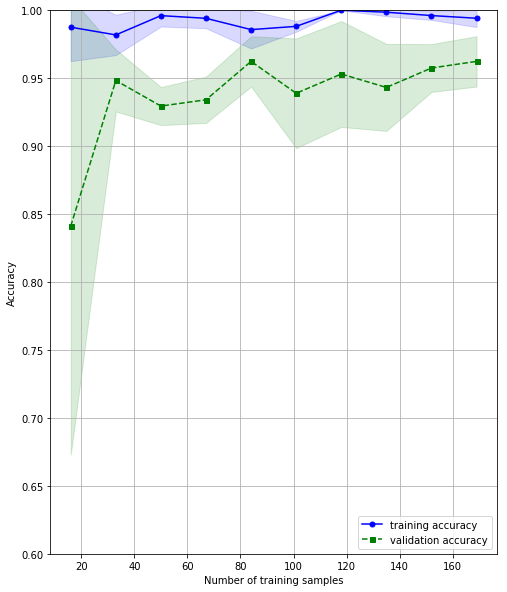

In [119]:
plot_learning_curve(random_foret, X_train, y_train)

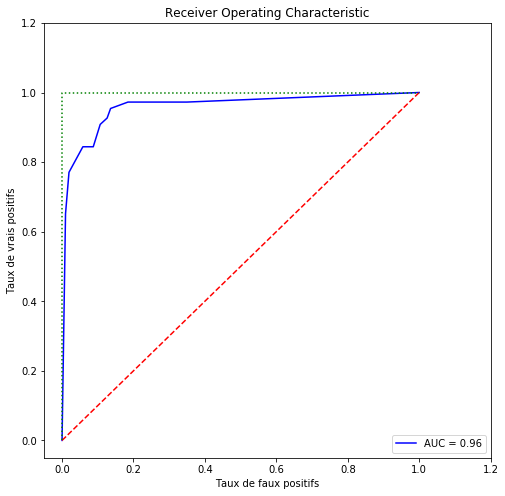

In [120]:
plot_roc_curve(random_foret,X_test,y_test)  # le reultat plutôt pas mal

## Gradient boosting

In [129]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()#
gb.fit(X_train,y_train)
y_gb = gb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_gb)
print(cm)
gb_score = metrics.accuracy_score(y_test, y_gb)
print(gb_score)
print(classification_report(y_test, y_gb))# on a une pertinance de 92%

# les résultats sont plutôt bons

[[ 94   9]
 [  9 100]]
0.9150943396226415
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       103
         1.0       0.92      0.92      0.92       109

   micro avg       0.92      0.92      0.92       212
   macro avg       0.92      0.92      0.92       212
weighted avg       0.92      0.92      0.92       212



c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


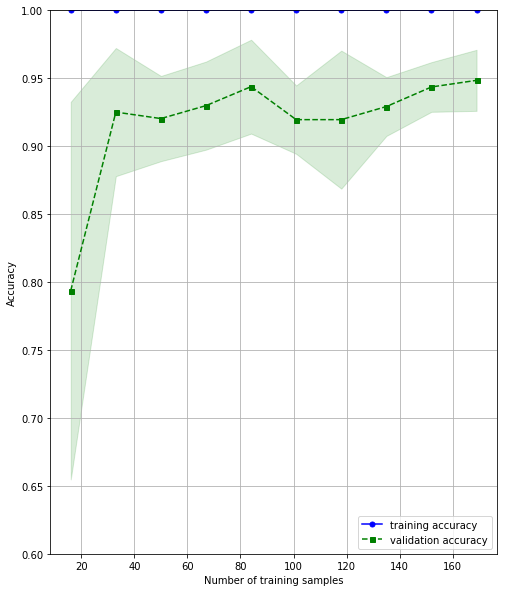

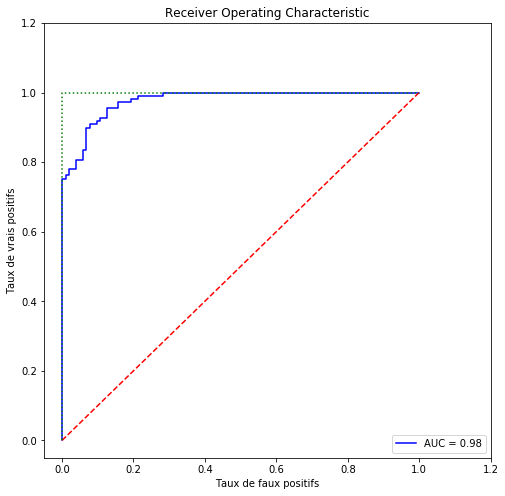

In [122]:
plot_learning_curve(gb, X_train, y_train)
plot_roc_curve(gb,X_test,y_test)

## Catboost 

In [123]:
i_discrete = [cancer.columns.get_loc(c) for c in cancer.columns if c not in import_data]
print(i_discrete)

[0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30]


In [124]:
i_discrete = [1, 3, 5, 6, 7, 8, 9]

In [125]:
cancer.describe()

id   diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  4.240000e+02  424.000000   424.000000    424.000000      424.000000   
mean   3.198668e+07    0.500000     0.192889      0.093384        0.197019   
std    1.307873e+08    0.500591     1.056467      0.984542        1.057095   
min    8.670000e+03    0.000000    -2.029648     -2.229249       -1.984504   
25%    8.682178e+05    0.000000    -0.621222     -0.595647       -0.595365   
50%    9.046680e+05    0.500000    -0.036153      0.023352       -0.029617   
75%    8.811587e+06    1.000000     0.920265      0.650497        0.917757   
max    9.113205e+08    1.000000     3.971288      4.651889        3.976130   

        area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count  424.000000       424.000000        424.000000      424.000000   
mean     0.187170         0.097711          0.113241        0.103751   
std      1.077356         0.013806          0.055469        0.082768   
min     -1.454443         0.062510          0.019380        0.000000   
25%     -0.608607         0.088108          0.070697        0.035430   
50%     -0.148573         0.097515          0.106950        0.087970   
75%      0.801712         0.106300          0.143000        0.152550   
max      5.250529         0.163400          0.345400        0.426800   

       concave points_mean           ...             radius_worst  \
count           424.000000           ...               424.000000   
mean              0.056818           ...                 0.204003   
std               0.041072           ...                 1.061606   
min               0.000000           ...                -1.726901   
25%               0.022890           ...                -0.613314   
50%               0.048920           ...                -0.046426   
75%               0.086260           ...                 0.893729   
max               0.201200           ...                 4.094189   

       texture_worst  perimeter_worst  area_worst  smoothness_worst  \
count     424.000000       424.000000  424.000000        424.000000   
mean        0.116259         0.208631    0.192645          0.134592   
std         1.009150         1.059785    1.082794          0.023139   
min        -2.223994        -1.693361   -1.222423          0.071170   
25%        -0.663543        -0.621741   -0.591596          0.118475   
50%         0.084317        -0.028631   -0.174883          0.134200   
75%         0.819149         0.914091    0.741693          0.149125   
max         3.885905         4.287337    5.930172          0.222600   

       compactness_worst  concavity_worst  concave points_worst  \
count         424.000000       424.000000            424.000000   
mean            0.281906         0.311104              0.128440   
std             0.167691         0.213198              0.067911   
min             0.027290         0.000000              0.000000   
25%             0.160300         0.139375              0.074158   
50%             0.245950         0.286350              0.123850   
75%             0.373850         0.431625              0.182000   
max             1.058000         1.170000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      424.000000               424.000000  
mean         0.296192                 0.100500  
std          0.066447                 1.063246  
min          0.156500                -1.601839  
25%          0.254725                -0.621395  
50%          0.287000                -0.153824  
75%          0.321700                 0.624907  
max          0.663800                 6.846856  

[8 rows x 32 columns]

# XGBoost

In [53]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
print(xgb.score(X_test,y_test))

0.9622641509433962


In [54]:
y_xgb = xgb.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_xgb)
print(conf_matrix)
xgb_score = metrics.accuracy_score(y_test, y_xgb)
print(xgb_score)

[[100   0]
 [  8 104]]
0.9622641509433962


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


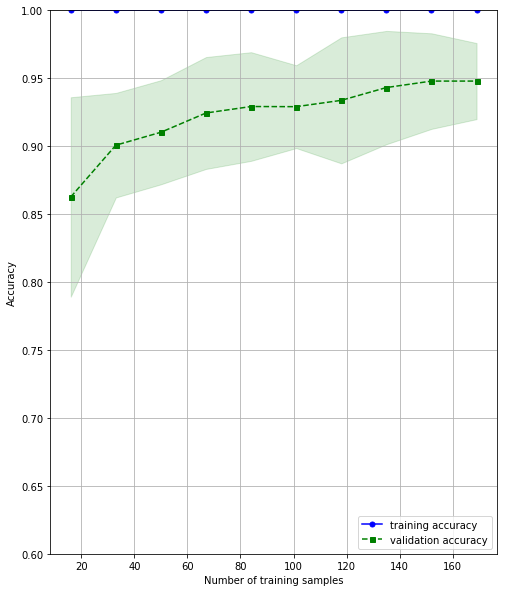

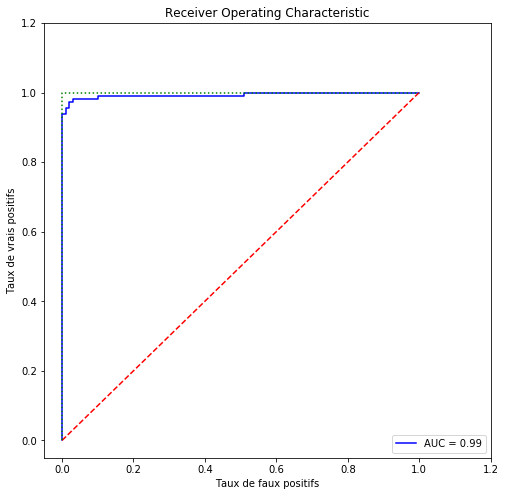

In [55]:
plot_learning_curve(xgb, X_train, y_train)
plot_roc_curve(xgb,X_test,y_test)

In [56]:
print(classification_report(y_test, y_xgb))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       100
         1.0       1.00      0.93      0.96       112

   micro avg       0.96      0.96      0.96       212
   macro avg       0.96      0.96      0.96       212
weighted avg       0.97      0.96      0.96       212

